In [55]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [56]:
import collections
import math
import os
import random 
import zipfile

In [57]:
from six.moves import urllib
from six.moves import xrange

In [58]:
import numpy as np
import tensorflow as tf

In [59]:
print(np.__version__)
print(tf.__version__)

1.18.1
2.1.0


In [60]:
Downloaded_Filename = 'WordEmbeddingData.zip'

def maybe_download(url_path, expected_bytes):
    if not os.path.exists(Downloaded_Filename):
        filename, _ = urllib.request.urlretrieve(url_path, Downloaded_Filename)
        
        statinfo = os.stat(Downloaded_Filename)
        if statinfo.st_size == expected_bytes:
            print('Found and verified file from this path: ', url_path)
            print('Downloaded file: ', Downloaded_Filename)
        else:
            print(statinfo.st_size)
            raise Exception(
            'failed to verify file from: ' + url_path + '. Can you get to it with a browser?')
        

In [61]:
def read_words():
    with zipfile.ZipFile(Downloaded_Filename) as f:
        firstfile = f.namelist()[0]
        filestring = tf.compat.as_str(f.read(firstfile))
        words = filestring.split()
        
    return words

In [62]:
URL_PATH = 'http://mattmahoney.net/dc/text8.zip'
FILESIZE = 31344016

maybe_download(URL_PATH, FILESIZE)

In [63]:
vocabulary = read_words()

In [64]:
len(vocabulary)

17005207

In [65]:
vocabulary[:25]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against',
 'early',
 'working',
 'class',
 'radicals',
 'including',
 'the',
 'diggers',
 'of',
 'the',
 'english',
 'revolution',
 'and',
 'the',
 'sans',
 'culottes']

In [66]:
def build_dataset(words, n_words):
    word_counts = [['UNLNOWN', -1]]
    
    counter = collections.Counter(words)
    word_counts.extend(counter.most_common(n_words - 1))
    
    dictionary = dict()
    
    for word, _ in word_counts:
        dictionary[word] = len(dictionary)
        
    word_indexes = list()
    
    unknown_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0 #dictionary['UNKNOWN']
            unknown_count += 1;
            
        word_indexes.append(index)
        
    word_counts[0][1] = unknown_count
    
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

    return word_counts, word_indexes, dictionary, reversed_dictionary

In [67]:
VOCABULARY_SIZE = 10000

word_counts, word_indexes, dictionary, reversed_dictionary = build_dataset(
    vocabulary, VOCABULARY_SIZE)

In [68]:
word_counts[:10]

[['UNLNOWN', 1737307],
 ('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201),
 ('a', 325873),
 ('to', 316376),
 ('zero', 264975),
 ('nine', 250430)]

In [69]:
word_indexes[:10]

[5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]

In [70]:
import random

for key in random.sample(list(dictionary), 10):
    print(key, ":", dictionary[key])

trapped : 7706
supremacy : 9811
soup : 7154
care : 1736
aligned : 6758
limitations : 5063
astronauts : 8187
lighting : 5185
herbert : 3382
being : 102


In [71]:
import random

for key in random.sample(list(reversed_dictionary), 10):
    print(key, ":", reversed_dictionary[key])

1852 : atoms
5486 : quote
8472 : mayo
9564 : leslie
6141 : permit
8105 : neighborhoods
7359 : pressed
4664 : atheism
3130 : varies
3855 : neo


In [72]:
del vocabulary

In [73]:
#global index into words maintained across batches
global_index = 0

In [74]:
def generate_batch(word_indexes, batch_size, num_skips, skip_window):
    global global_index
    
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape = (batch_size), dtype=np.int32)
    labels = np.ndarray(shape = (batch_size, 1), dtype=np.int32)
    
    span = 2 * skip_window + 1 #[ skip_window input_word skip_window ]
    
    buffer = collections.deque(maxlen = span)
    
    for _ in range(span):
        buffer.append(word_indexes[global_index])
        global_index = (global_index + 1) % len(word_indexes)
        
    for i in range(batch_size // num_skips):
        target = skip_window #input word at the center of the buffer
        targets_to_avoid = [skip_window]
        
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
                
            targets_to_avoid.append(target)
            
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
            
        buffer.append(word_indexes[global_index])
        global_index = (global_index + 1) % len(word_indexes)
        
    global_index = (global_index + len(word_indexes) - span) % len(word_indexes)
    
    return batch, labels


In [75]:
batch, labels = generate_batch(word_indexes, 10, 2, 5)

In [76]:
batch

array([   2,    2, 3134, 3134,   46,   46,   59,   59,  156,  156],
      dtype=int32)

In [77]:
labels

array([[3081],
       [3134],
       [ 156],
       [   6],
       [  59],
       [ 128],
       [   2],
       [  46],
       [  46],
       [ 477]], dtype=int32)

In [78]:
for i in range(9):
    print(reversed_dictionary[batch[i]], ":", reversed_dictionary[labels[i][0]])

of : originated
of : abuse
abuse : against
abuse : a
first : used
first : early
used : of
used : first
against : first


In [79]:
global_index = 0

In [80]:
valid_size = 16
valid_window = 100

valid_examples = np.random.choice(valid_window, valid_size, replace = False)

In [81]:
num_samples = 64

In [82]:
batch_size = 128
embedding_size = 50
skip_window = 2
num_skips = 2

In [83]:
tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()

train_inputs = tf.compat.v1.placeholder(tf.int32, shape = [batch_size])
train_labels = tf.compat.v1.placeholder(tf.int32, shape = [batch_size, 1])

In [84]:
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [85]:
embeddings = tf.Variable(
    tf.compat.v1.random_uniform([VOCABULARY_SIZE, embedding_size], -1.0, 1.0))

embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [86]:
embeddings

<tf.Variable 'Variable:0' shape=(10000, 50) dtype=float32>

In [87]:
embed

<tf.Tensor 'embedding_lookup/Identity_1:0' shape=(128, 50) dtype=float32>

In [88]:
nce_weights = tf.Variable(tf.compat.v1.truncated_normal([VOCABULARY_SIZE, embedding_size],
                                         stddev = 1.0 / math.sqrt(embedding_size)))

nce_biases = tf.Variable(tf.zeros([VOCABULARY_SIZE]))

In [89]:
loss = tf.reduce_mean(
tf.nn.nce_loss(weights = nce_weights,
              biases = nce_biases,
              labels = train_labels,
              inputs = embed,
              num_sampled = num_samples,
              num_classes = VOCABULARY_SIZE))

In [90]:
optimizer = tf.compat.v1.train.GradientDescentOptimizer(0.1).minimize(loss)

In [91]:
l2_norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, True))

normalized_embeddings = embeddings / l2_norm

In [92]:
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)

In [93]:
valid_embeddings

<tf.Tensor 'embedding_lookup_1/Identity:0' shape=(16, 50) dtype=float32>

In [94]:
normalized_embeddings

<tf.Tensor 'truediv:0' shape=(10000, 50) dtype=float32>

In [95]:
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [96]:
init = tf.compat.v1.global_variables_initializer()

In [97]:
num_steps = 200001

In [100]:
with tf.compat.v1.Session() as session:
    init.run()
    
    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(
        word_indexes, batch_size, num_skips, skip_window)
        
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        
        _, loss_val = session.run([optimizer, loss], feed_dict)
        average_loss += loss_val
        
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
                
                print('Average_loss at step ', step, ':', average_loss)
                average_loss = 0
                    
        if step % 10000 == 0:
            sim = similarity.eval()
        
            for i in xrange(valid_size):
                valid_word = reversed_dictionary[valid_examples[i]]
                top_k = 8
                
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest tp %s:' % valid_word
                
                for k in xrange(top_k):
                    close_word = reversed_dictionary[nearest[k]]
                    log_str = '%s %s,' % (log_str, close_word)
                print(log_str)
                
            print("\n")
        
    final_embeddings = normalized_embeddings.eval()    
    

Nearest tp a: yourself, strauss, recognition, sterling, account, nashville, ion, culture,
Nearest tp four: diodes, potentially, creed, hercules, int, alliance, insubstantial, bible,
Nearest tp would: empires, treaties, seeks, yield, shuttle, dns, bud, electrical,
Nearest tp will: separate, peel, tunnels, park, piece, brief, slam, editors,
Nearest tp three: audiences, bank, municipal, database, scrimmage, sisters, knowledge, been,
Nearest tp six: source, molecules, argue, that, colombia, filmmakers, holocaust, discover,
Nearest tp d: submarine, periodic, grants, coefficient, feminist, messenger, horse, goods,
Nearest tp during: planted, populous, soundtrack, renamed, monopoly, tough, provision, miami,
Nearest tp an: learning, popular, transformations, nationalism, indeed, airlines, sphere, erie,
Nearest tp all: statue, involved, intersection, feminism, everyone, idealism, goths, obey,
Nearest tp five: retrieved, rover, fundamental, gdp, occur, decimal, iliad, shares,
Nearest tp while: l

Average_loss at step  52000 : 5.389175998210907
Average_loss at step  54000 : 5.462215971469879
Average_loss at step  56000 : 5.423772497892379
Average_loss at step  58000 : 5.164232918143273
Average_loss at step  60000 : 5.270128281235695
Nearest tp a: the, and, an, UNLNOWN, how, in, was, recognition,
Nearest tp four: seven, six, one, alliance, insubstantial, child, three, eight,
Nearest tp would: write, whereas, shall, electrical, treaties, circumstances, basic, loop,
Nearest tp will: separate, top, truth, part, content, do, brief, piece,
Nearest tp three: two, warfare, functions, h, establishment, eight, commercial, five,
Nearest tp six: nine, four, zero, territory, seven, x, plants, pro,
Nearest tp d: at, fascism, horse, roosevelt, take, change, import, analysis,
Nearest tp during: renamed, earliest, various, monopoly, james, frequency, moved, obsolete,
Nearest tp an: learning, popular, a, indeed, the, culture, e, line,
Nearest tp all: feminism, statue, involved, goths, uk, basebal

Average_loss at step  112000 : 4.863554010868072
Average_loss at step  114000 : 4.842635923147202
Average_loss at step  116000 : 4.7857664668560025
Average_loss at step  118000 : 4.823161572575569
Average_loss at step  120000 : 4.8459064300060275
Nearest tp a: the, an, its, recognition, how, ion, pointer, extensions,
Nearest tp four: six, seven, eight, three, one, alliance, two, zero,
Nearest tp would: monaco, ecumenical, patch, whereas, treaties, basic, shuttle, write,
Nearest tp will: separate, top, truth, count, peel, brief, content, leaders,
Nearest tp three: two, four, five, eight, zero, functions, seven, nine,
Nearest tp six: four, nine, seven, zero, eight, miss, two, three,
Nearest tp d: at, submarine, incorporate, functional, logical, analysis, training, and,
Nearest tp during: renamed, monopoly, earliest, participation, obsolete, various, twin, populous,
Nearest tp an: a, learning, the, indeed, popular, verbs, microwave, height,
Nearest tp all: feminism, statue, involved, goth

Average_loss at step  172000 : 4.776969535946846
Average_loss at step  174000 : 4.781437743186951
Average_loss at step  176000 : 4.775818629622459
Average_loss at step  178000 : 4.781248422384262
Average_loss at step  180000 : 4.76911829161644
Nearest tp a: an, the, its, ion, recognition, how, pointer, extensions,
Nearest tp four: six, seven, three, eight, one, two, zero, nine,
Nearest tp would: monaco, ecumenical, basic, patch, funk, rabbis, accurate, whereas,
Nearest tp will: top, separate, count, truth, dartmouth, brief, peel, do,
Nearest tp three: two, five, four, eight, zero, seven, six, one,
Nearest tp six: four, seven, nine, zero, eight, three, five, two,
Nearest tp d: incorporate, submarine, at, logical, genes, functional, july, grants,
Nearest tp during: monopoly, participation, renamed, obsolete, earliest, various, twin, resolve,
Nearest tp an: a, the, learning, indeed, popular, verbs, transformations, microwave,
Nearest tp all: feminism, statue, goths, painting, moroccan, ru

In [101]:
def save_words_embeddings(embeddings, word_counts):
    np.save('embeddings.npy', embeddings)
    
    words = [x[0] for x in word_counts]
    np.save('words.pny', words)
    
save_words_embeddings(final_embeddings, word_counts)

In [109]:
import matplotlib.pyplot as plt

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    
    plt.figure(figsize = (18, 18))
    
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        
        plt.scatter(x, y)
        
        plt.annotate(label, 
                    xy = (x, y),
                    xytext = (5, 2),
                    textcoords = 'offset points',
                    ha = 'right',
                    va = 'bottom')
    plt.savefig(filename)
    plt.show(filename)

In [107]:
from sklearn.manifold import TSNE
NUM_PLOT_POINTS = 500

tsne = TSNE(perplexity=30, n_components = 2, init = 'pca', n_iter=5000, method='exact')

low_dim_embs = tsne.fit_transform(final_embeddings[:NUM_PLOT_POINTS, :])

labels = [reversed_dictionary[i] for i in xrange(NUM_PLOT_POINTS)]

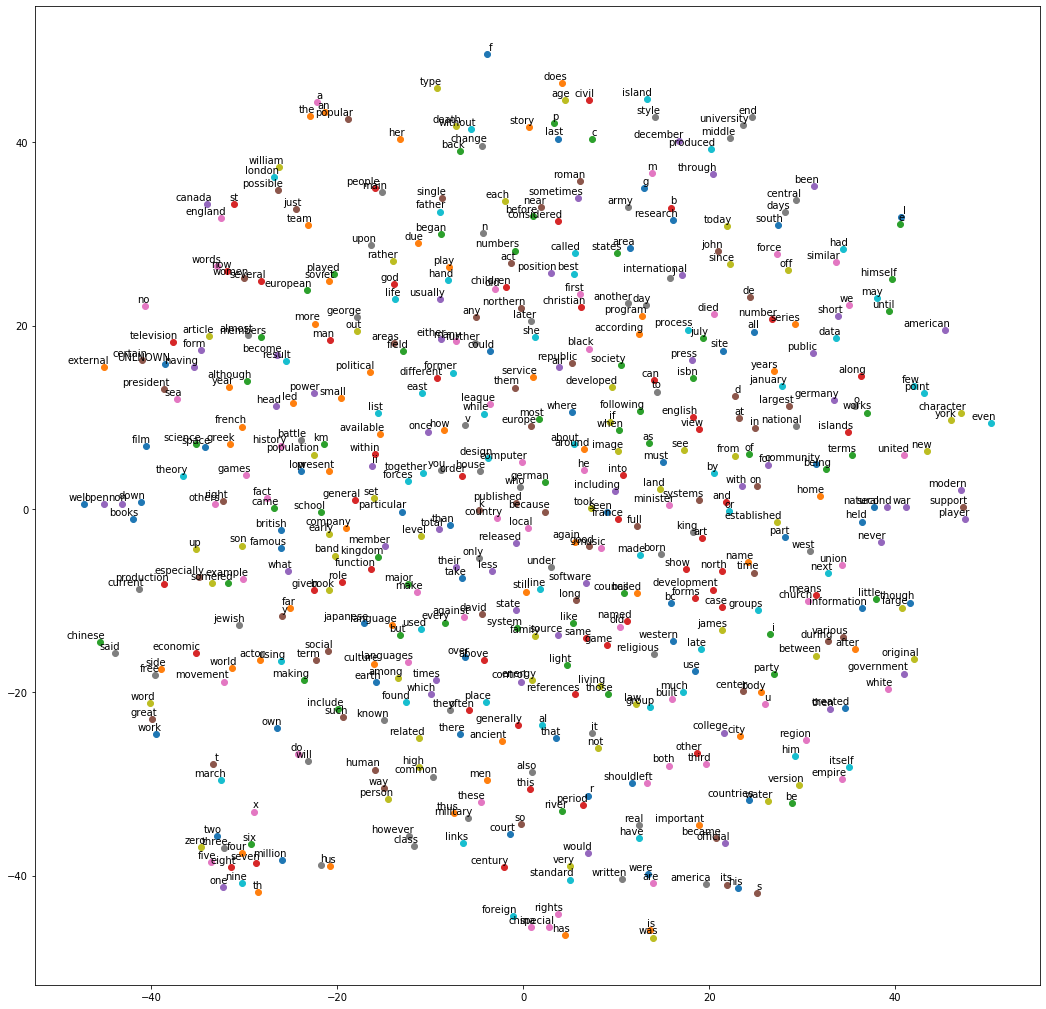

In [110]:
plot_with_labels(low_dim_embs, labels)